In [2]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
from suite3d import nbtools as nbui

In [5]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-06',
    'expnum' :         [1,2,3,4]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21])[n.array([6,7,8,9,10,11,12])],
    # number of files to use for the initial pass
    'n_init_files' :   3,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 7,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str + 'subset', tifs = tifs[:20],
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset already exists
Loading job directory for SS003_2024-08-06_1-2-3-4subset in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [6]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

In [7]:
# %%time
# job.run_init_pass()

In [8]:
img3d = job.load_summary()['ref_img_3d']

(<Figure size 1050x750 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f57b73f5850>)

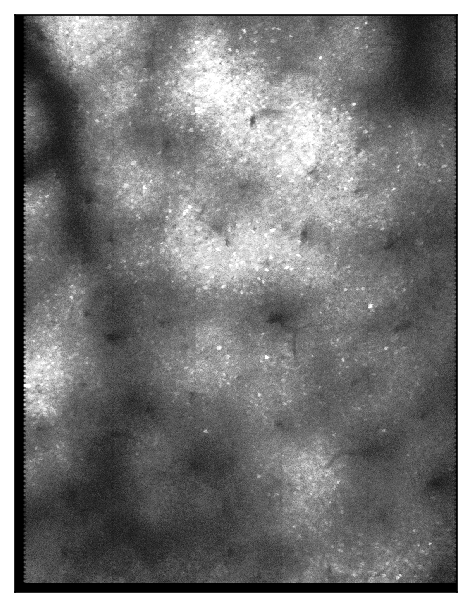

In [9]:
tfu.show_tif(img3d[0], figsize=(7,5))

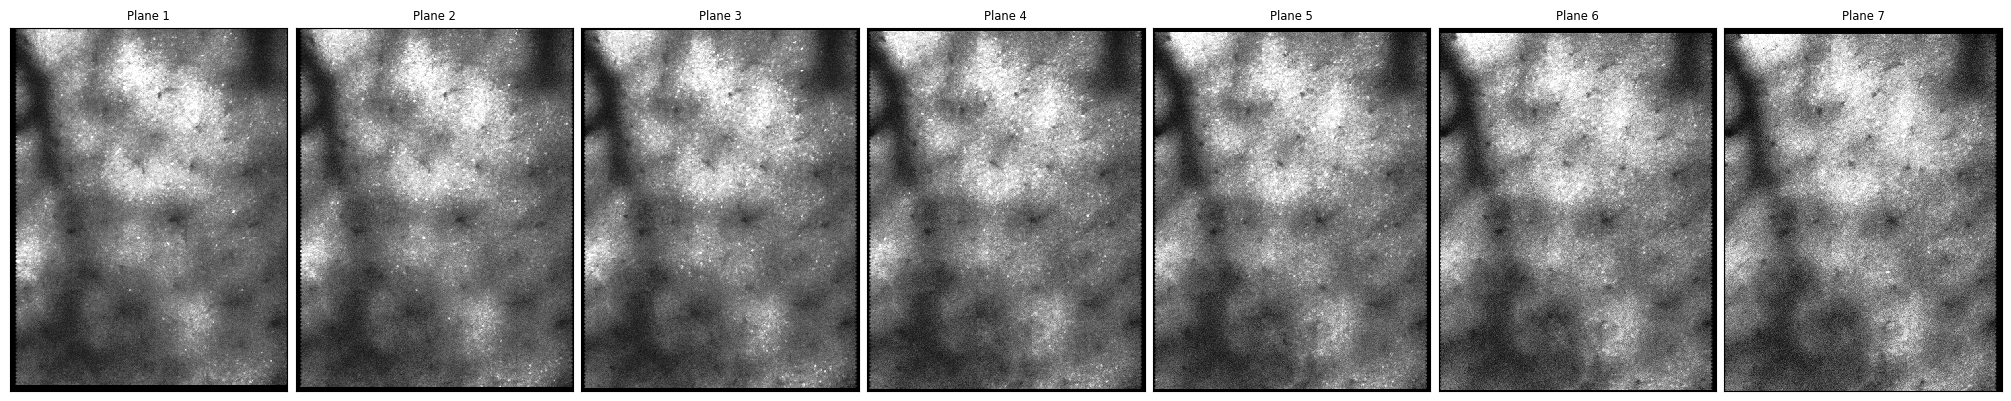

In [10]:
tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,5))

In [12]:
# # SAVE DATA FOR s2p Run
# from suite3d.io.s3dio import s3dio
# from suite3d import reference_image as ref
# import tifffile

# jobio = s3dio(job)

# raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/raw'

# os.makedirs(raw_data_path,exist_ok=True)

# planes = n.array([6,7,8,9,10,11,12])
# fuse_shift = 7
# ys, xs = jobio._load_roi_start_pix_lbm(job.params)
# for tif in job.tifs[:20]:
#     print(tif)
#     data = jobio.load_data([tif], planes = job.params['planes'])
#     out_fname = tif.split('/')[-1].split('.')[0] + f'_{len(planes)}planes.tif'
#     out_path = os.path.join(raw_data_path, out_fname)
#     data = ref.fuse_mov(data, fuse_shift, n.sort(xs))[0]
#     data = n.swapaxes(data,0,1)        
#     tifffile.imsave(out_path, data)

In [16]:
mov = job.get_registered_movie()

In [17]:
reg = job.load_registration_results()

In [18]:
job.dirs['registered_fused_data']

'/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data'

In [19]:
reg.keys()

dict_keys(['phase_corr_shifted', 'int_shift', 'pc_peak_loc', 'sub_pixel_shifts', 'metrics'])

In [20]:
phase_corrs = n.concatenate(reg['phase_corr_shifted'])

In [21]:
phase_corrs.shape

(2000, 5, 81, 81)

In [69]:
mean_phase_corrs = phase_corrs.mean(axis=0)

In [71]:
phase_corrs.shape

(2000, 5, 81, 81)

In [26]:
times = [745, 1677,   28,   41 ,  44 ,1674]

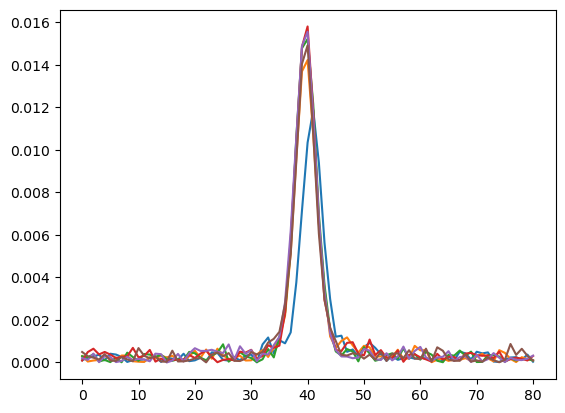

In [29]:
for time in times:
    plt.plot(phase_corrs[time,2,40])

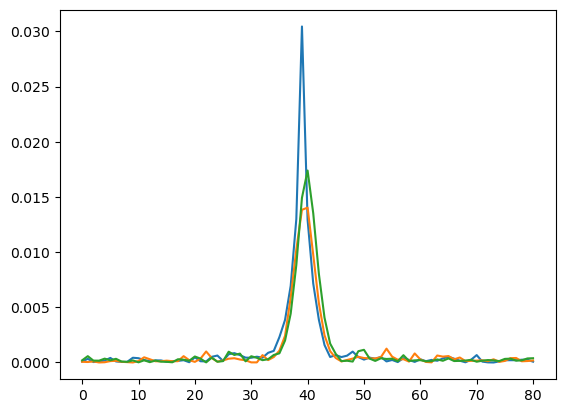

In [24]:
plt.plot(phase_corrs[1000,2,40])
plt.plot(phase_corrs[1100,2,40])
plt.plot(phase_corrs[1400,2,40])

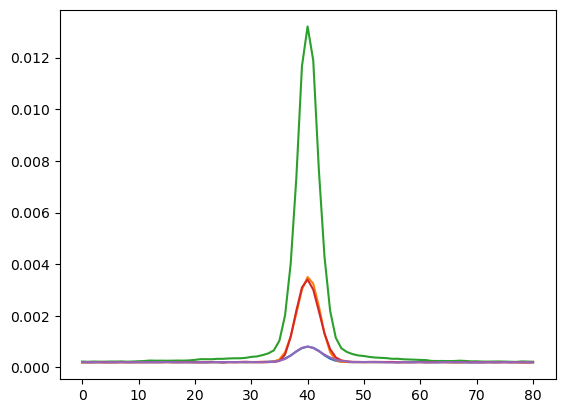

In [78]:
plt.plot(mean_phase_corrs[0,40])
plt.plot(mean_phase_corrs[1,40])
plt.plot(mean_phase_corrs[2,40])
plt.plot(mean_phase_corrs[3,40])
plt.plot(mean_phase_corrs[4,40])

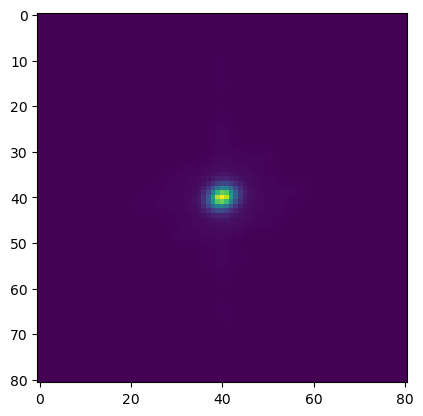

In [72]:
plt.imshow(mean_phase_corrs[2])

In [68]:
phase_corrs.shape

(2000, 5, 81, 81)

In [54]:
os.listdir(job.dirs['registered_fused_data'])

['fused_reg_data0005.npy',
 'reg_metrics_0004.npy',
 'offsets0016.npy',
 'fused_reg_data0002.npy',
 'reg_metrics_0012.npy',
 'fused_reg_data0010.npy',
 'fused_reg_data0009.npy',
 'reg_metrics_0005.npy',
 'mean_img_0004.npy',
 'mean_img_0007.npy',
 'fused_reg_data0006.npy',
 'reg_metrics_0006.npy',
 'mean_img_0009.npy',
 'mean_img_0010.npy',
 'fused_reg_data0011.npy',
 'params.npy',
 'reg_metrics_0009.npy',
 'offsets0004.npy',
 'reg_metrics_0011.npy',
 'mean_img_0003.npy',
 'fused_reg_data0013.npy',
 'offsets0010.npy',
 'reg_metrics_0015.npy',
 'fused_reg_data0001.npy',
 'reg_metrics_0001.npy',
 'mean_img_0015.npy',
 'fused_reg_data0007.npy',
 'fused_reg_data0016.npy',
 'fused_reg_data0004.npy',
 'reg_metrics_0019.npy',
 'reg_metrics_0010.npy',
 'mean_img_0006.npy',
 'mean_img_0013.npy',
 'reg_metrics_0000.npy',
 'offsets0018.npy',
 'offsets0000.npy',
 'reg_metrics_0007.npy',
 'offsets0003.npy',
 'mean_img_0011.npy',
 'fused_reg_data0018.npy',
 'fused_reg_data0000.npy',
 'mean_img_0014.

In [28]:
job.params['fs']

4.116358658453114

In [29]:
reg.keys()

dict_keys(['phase_corr_shifted', 'int_shift', 'pc_peak_loc', 'sub_pixel_shifts', 'metrics'])

In [38]:
# spshift = n.concatenate(reg['sub_pixel_shifts'],axis=0)
# intshift = n.concatenate(reg['int_shift'],axis=0)

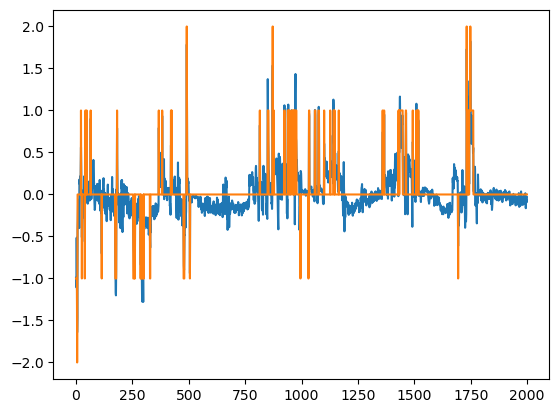

In [39]:
plt.plot(spshift[:,1])
plt.plot(intshift[:,1])

15.0

In [ ]:
%%time
job.params['voxel_size_um'] = (20, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200
job.params['npil_filt_z_um'] = 40

job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['cell_filt_z_um'] = 30
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 1.0 # original run with 0.1
corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/corrmap
   Updated main params file
   Computing correlation map of movie with 2000 frames, volume shape: 7, 914, 699
      Running batch 1 of 10
         Timer prep completed in 2.017 sec
         Timer batch_setup completed in 0.828 sec
         Timer batch_edgecrop completed in 0.052 sec
         Timer accum_meanmeax completed in 0.697 sec
         Timer batch_rolling_mean_filt completed in 0.666 sec
         Timer batch_accum_sdmov completed in 2.066 sec
         Timer batch_norm_sdmov completed in 0.341 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 2.844 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d comple

In [132]:
corr_map = job.load_corr_map_results()['vmap']

In [133]:
from suite3d import extension as ext

In [134]:
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

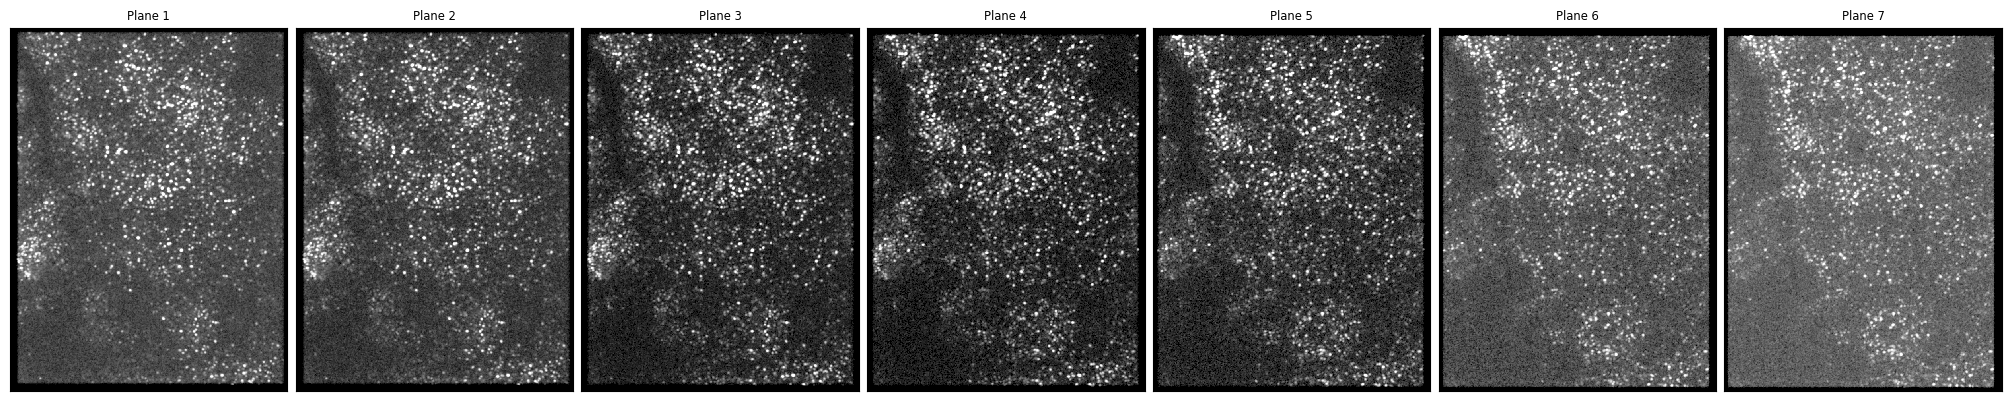

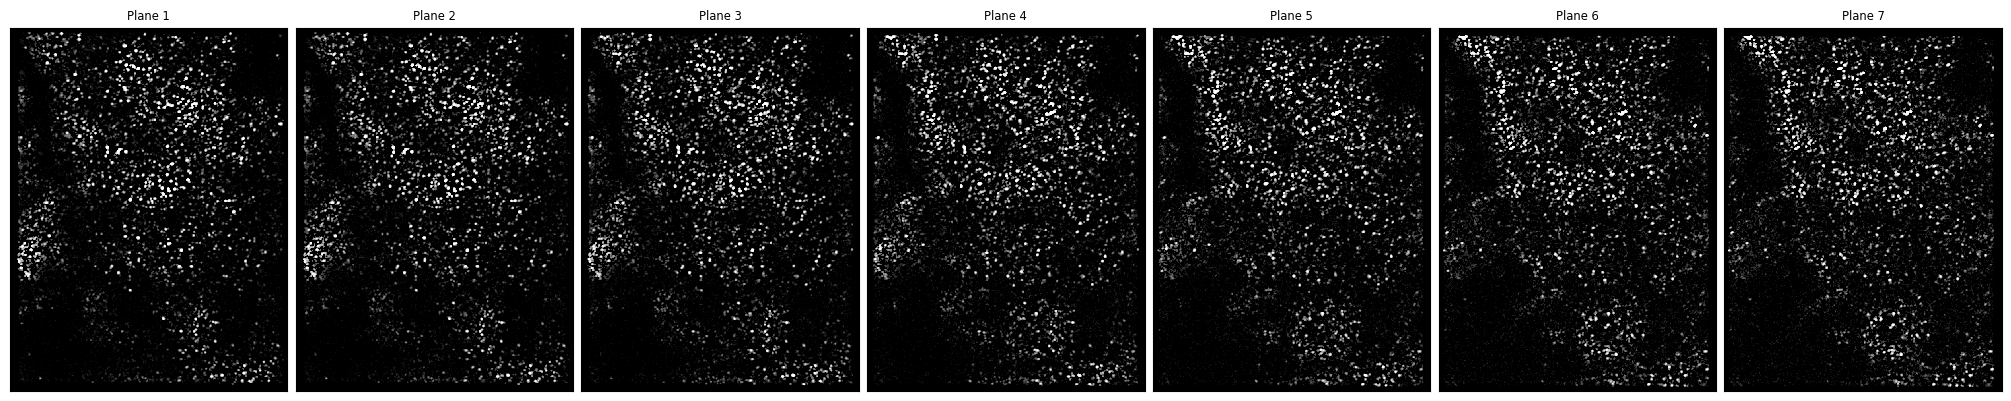

In [135]:
tfu.show_tif_all_planes(corr_map, ncols=7, figsize=(20,5))
tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5))

In [ ]:
tfu.show_tif(corr_map[3],vminmax_percentile=(20,99))

In [ ]:
corr_map_thresh.shape

In [ ]:
tfu.show_tif(corr_map_thresh[3, 300:600, 320:620],vminmax_percentile=(20,99), cmap='Greys')

In [ ]:
tfu.show_tif(corr_map_thresh[3, 300:600, 320:620],vminmax_percentile=(20,99))

In [ ]:
tfu.show_tif(corr_map_thresh[3],vminmax_percentile=(20,99), cmap='Greys')

In [ ]:
tfu.show_tif(corr_map_thresh[3],vminmax_percentile=(20,99))

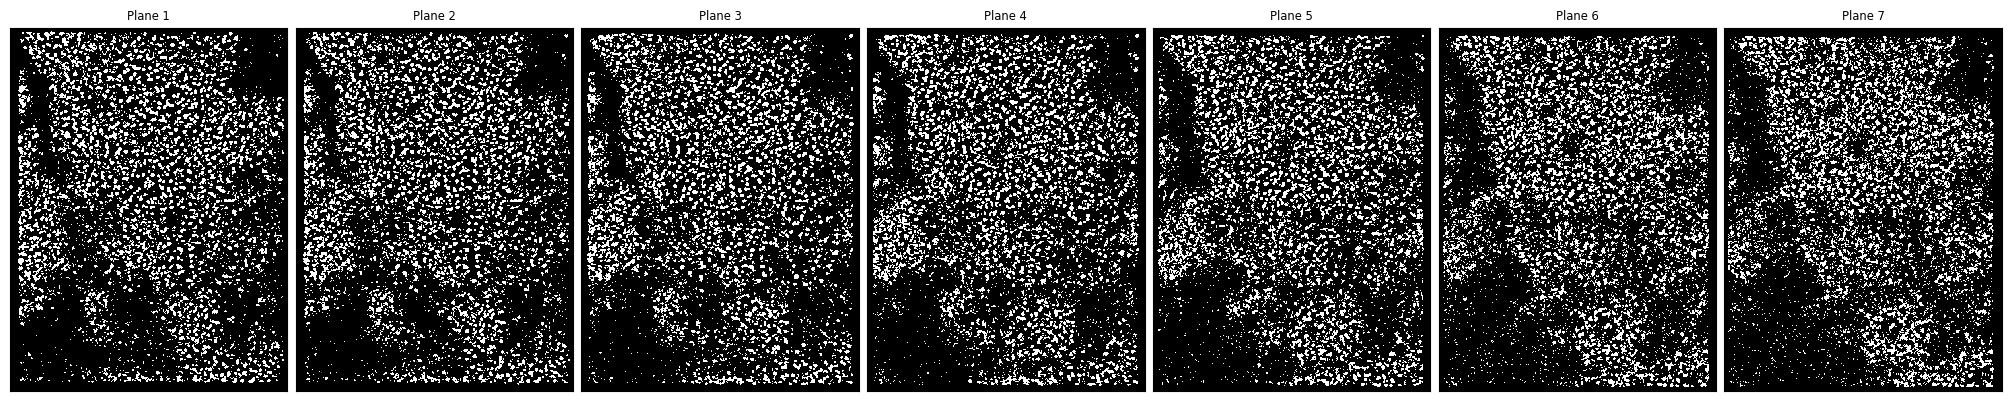

In [35]:

tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5), vminmax=(0.015,0.0151))

In [49]:
%%time
job.params['peak_thresh'] = 0.015
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.05
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 64
job.params['patch_size_xy'] = (250, 250)

# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=corr_map_thresh)

   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation with tag segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation
   Updated main params file
   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois with tag rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation and /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 12
   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation/patch-0000 with tag segmentation-patch-0000
         Loading 3.26 GB movie to memory, shape: (2000, 7, 250, 250) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.015 and Th2: 5.000
         Iter 0000: running 64 ROIs in parallel
         Ad

'/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois'

In [12]:
seg = job.load_segmentation_results()

      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/iscell.npy


In [105]:
mov3d = job.get_registered_movie()[:,:1000].compute()

In [106]:
nz, nt, ny, nx = mov3d.shape

movstd = mov3d.std(axis=0)

In [107]:
meds = n.array([s['med'] for s in seg['stats']])

vpeaks = n.array([s['peak_val'] for s in seg['stats']])

In [108]:
rand_idxs = n.random.choice(n.where((vpeaks > 0.1))[0], 1000, replace=False)

In [109]:
wz = 7
wxy = 50

In [110]:
acc = n.zeros((wz*2+1,wxy*2+1, wxy*2+1))
sumx = n.zeros((wz*2+1,wxy*2+1,wxy*2+1))
i = 0
for idx in rand_idxs:
    if i % 50 == 0:
        print(i  )
    i += 1
    med = meds[idx]

    mz, my, mx =med
    miny = max(0, my - wxy)
    maxy = min(ny, my + wxy)
    dyl = my - miny
    dyh = maxy - my
    
    minx = max(0, mx - wxy)
    maxx = min(nx, mx + wxy)
    dxl = mx - minx
    dxh = maxx - mx
    
    minz = max(0, mz - wz)
    maxz = min(nz, mz + wz)
    dzl = mz - minz
    dzh = maxz - mz
    
    movpix = mov3d[mz,:, my, mx].copy()
    movcube = mov3d[minz:maxz, :, miny:maxy, minx:maxx].copy()
    movcube = n.swapaxes(movcube, 0, 1).reshape(nt, -1)
    
    cubestd = movstd[minz:maxz, miny:maxy, minx:maxx].copy()
    movcube_shape = cubestd.shape
    cubestd = cubestd.flatten()
    
    movcube -= movcube.mean(axis=0)
    movpix -= movpix.mean(axis=0)
    
    corrs = ((movcube * movpix[:,n.newaxis]).mean(axis=0) / (movpix.std() * cubestd + 1e-10))
    corrs[n.abs(corrs) > 1] = 0
    acc[wz - dzl : wz + dzh, wxy - dyl : wxy + dyh, wxy - dxl : wxy + dxh] += corrs.reshape(*movcube_shape)
    sumx[wz - dzl : wz + dzh, wxy - dyl : wxy + dyh, wxy - dxl : wxy + dxh] += 1

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [111]:

from suite3d import plot_utils as plot

In [112]:
map = acc / sumx

/tmp/ipykernel_914106/3907557198.py:1: RuntimeWarning: invalid value encountered in divide
  map = acc / sumx


In [115]:
job.params['voxel_size_um']

(20, 2.5, 2.5)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f57ae57e130>)

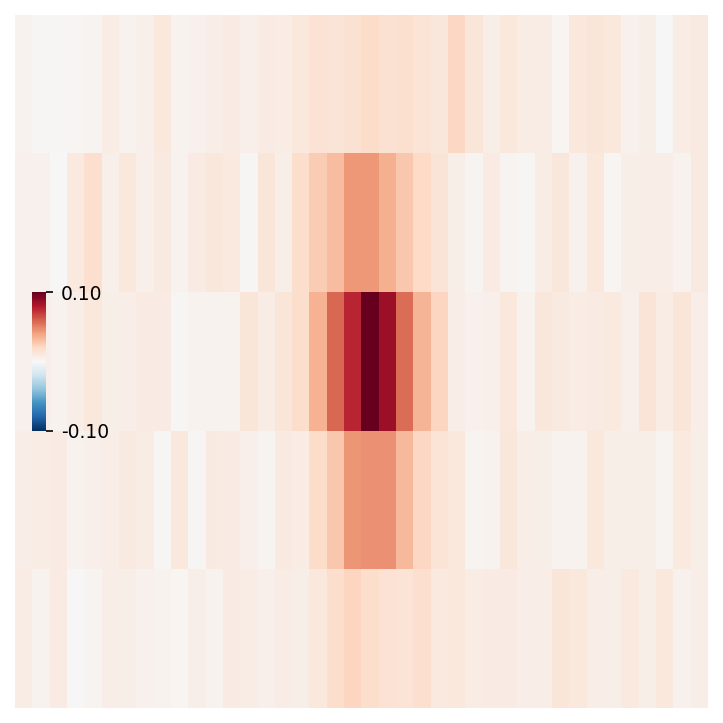

In [129]:
plot.show_img(map[wz-2:wz+3,wxy, wxy-20:wxy+20], vminmax=(-0.1,0.1), cmap='RdBu_r',px_py = (1,8), cbar=True)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f57ae3df460>)

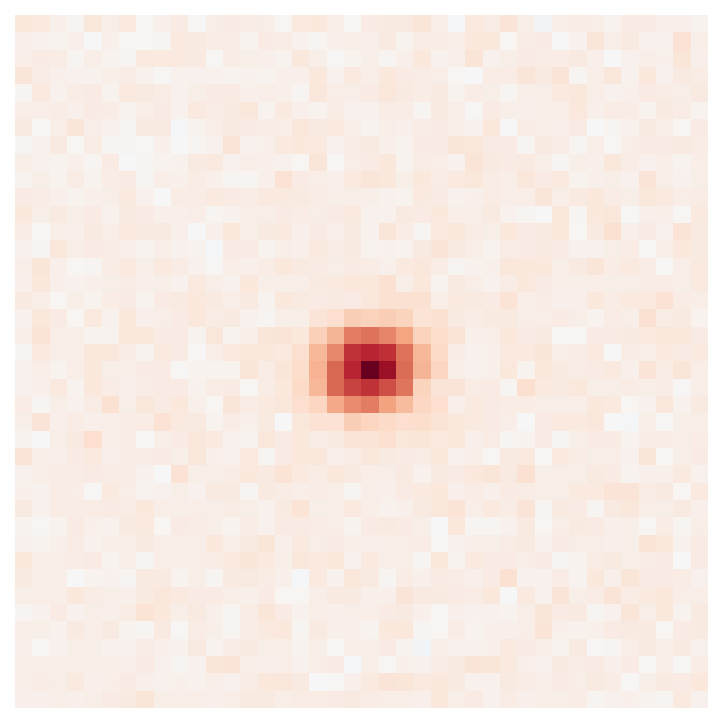

In [130]:
plot.show_img(map[7, wxy-20:wxy+20, wxy-20:wxy+20], vminmax=(-0.1,0.1), cmap='RdBu_r')

In [141]:
not_cell_flag = corr_map_thresh < 0.0001

In [145]:
not_cell_pix = n.stack(n.where(not_cell_flag)).T

In [193]:
rand_pix_idxs = n.random.choice(n.arange(not_cell_pix.shape[0]), 1000,replace=False)

In [194]:
rand_pix_idx = rand_pix_idxs[0]

In [201]:
not_cell_pix[rand_pix_idx]

array([  1, 821, 371])

In [206]:
movcube.shape

(1000, 70000)

In [207]:
np_acc = n.zeros((wz*2+1,wxy*2+1, wxy*2+1))
np_sumx = n.zeros((wz*2+1,wxy*2+1,wxy*2+1))
i = 0
for rand_pix_idx in rand_pix_idxs:
    if i % 50 == 0:
        print(i  )
    i += 1
    med = not_cell_pix[rand_pix_idx]

    mz, my, mx =med
    miny = max(0, my - wxy)
    maxy = min(ny, my + wxy)
    dyl = my - miny
    dyh = maxy - my
    
    minx = max(0, mx - wxy)
    maxx = min(nx, mx + wxy)
    dxl = mx - minx
    dxh = maxx - mx
    
    minz = max(0, mz - wz)
    maxz = min(nz, mz + wz)
    dzl = mz - minz
    dzh = maxz - mz
    
    flag_cube = not_cell_flag[minz:maxz, miny:maxy, minx:maxx]
    movpix = mov3d[mz,:, my, mx].copy()
    movcube = mov3d[minz:maxz, :, miny:maxy, minx:maxx].copy()
    movcube = n.swapaxes(movcube, 0, 1)
    break
    movcube = movcube.reshape(nt, -1)
    
    cubestd = movstd[minz:maxz, miny:maxy, minx:maxx].copy()
    movcube_shape = cubestd.shape
    cubestd = cubestd.flatten()
    
    movcube -= movcube.mean(axis=0)
    movpix -= movpix.mean(axis=0)
    
    corrs = ((movcube * movpix[:,n.newaxis]).mean(axis=0) / (movpix.std() * cubestd + 1e-10))
    corrs[n.abs(corrs) > 1] = 0

    corrs = corrs.reshape(movcube_shape)
    flag_cube = not_cell_flag[minz:maxz, miny:maxy, minx:maxx]
    corrs[~flag_cube] = 0
    ind = n.ones_like(corrs)
    ind[~flag_cube] = 0
    
    # np_acc[wz - dzl : wz + dzh, wxy - dyl : wxy + dyh, wxy - dxl : wxy + dxh] += corrs
    # np_sumx[wz - dzl : wz + dzh, wxy - dyl : wxy + dyh, wxy - dxl : wxy + dxh] += ind

0


In [210]:
movcube[:,flag_cube]

IndexError: boolean index did not match indexed array along dimension 3; dimension is 58 but corresponding boolean dimension is 100

In [196]:
np_map = np_acc / np_sumx

/tmp/ipykernel_914106/2722663513.py:1: RuntimeWarning: invalid value encountered in divide
  np_map = np_acc / np_sumx


(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f57addbf310>)

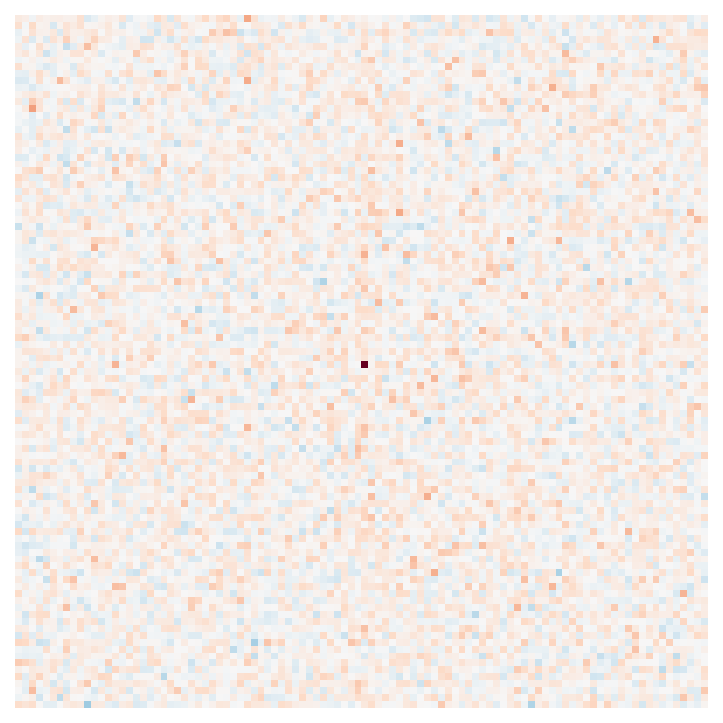

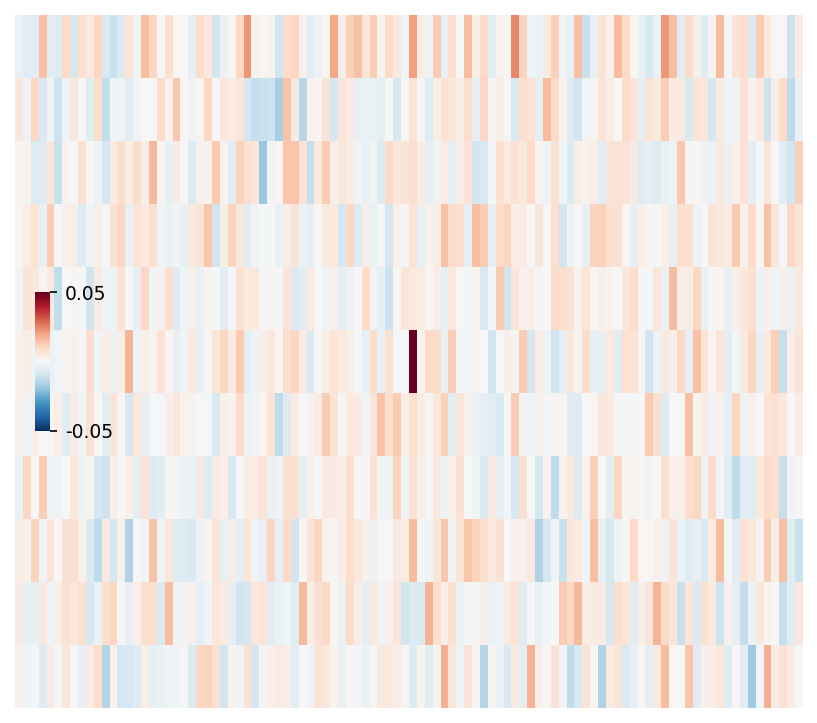

In [199]:
pxy = 50
pz = 5

vs = 0.05
plot.show_img(np_map[wz, wxy-pxy:wxy+pxy, wxy-pxy:wxy+pxy], vminmax=(-vs,vs), cmap='RdBu_r')
# plot.show_img(np_map[wz], vminmax=(-.5,.5), cmap='RdBu_r')
plot.show_img(np_map[wz-pz:wz+pz+1,wxy, wxy-pxy:wxy+pxy], vminmax=(-vs,vs), cmap='RdBu_r',px_py = (1,8), cbar=True)

In [155]:
np_acc.shape

(15, 101, 101)

In [92]:
len(meds)

11413

In [52]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')#, additional_info = job.load_corr_map_results())

IOStream.flush timed out
IOStream.flush timed out


   Updated main params file
   Movie shape: (7, 2000, 914, 699)
11413
   Extracting 11413 valid cells, and saving cell flags to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 4 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois
            Extracting batch 0000 of 0004
            Batch size: 8 GB
            Extracting batch 0001 of 0004
            Batch size: 8 GB
            Extracting batch 0002 of 0004
            Batch size: 8 GB
            Extracting batch 0003 of 0004
            Batch size: 8 GB
   Deconvolving
   Saving to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois
   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-06_1-2-3-4subset to export results
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/info.npy
      

In [53]:
seg = job.load_segmentation_results()
shape = seg['info']['vmap'].shape
cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], shape, lam_max=0.1, cmap='Set1')
nbui.ImageSliceViewer3D(corr_map_thresh,cmap='Greys',vminmax=(job.params['peak_thresh'],job.params['peak_thresh']*2), overlay=rgb_vol, alpha=0.5)

      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [119]:
reg = job.load_registration_results()

In [120]:
shifts = n.concatenate(reg['int_shift'],axis=0)
sp_shifts = n.concatenate(reg['sub_pixel_shifts'], axis=0)

(0.0, 100.0)

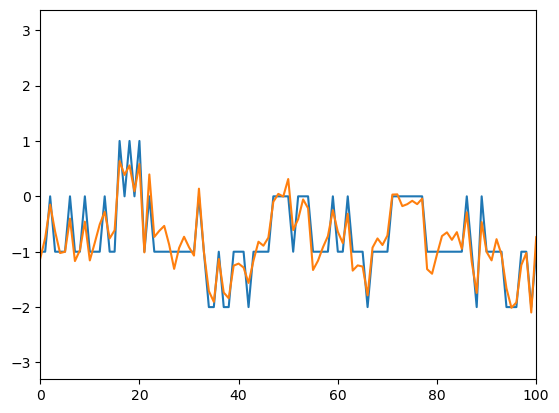

In [121]:
plt.plot(shifts[:,2])
plt.plot(sp_shifts[:,2])
plt.xlim(0,100)

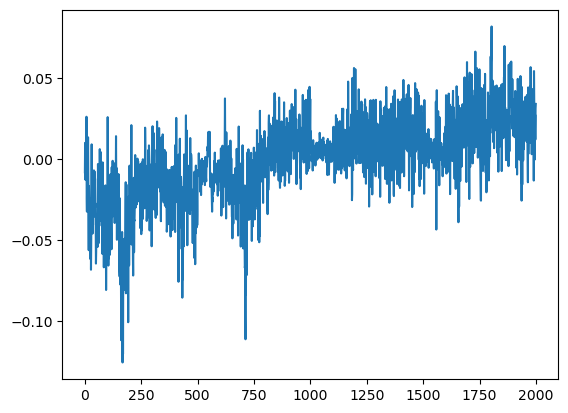

In [122]:
plt.plot(sp_shifts[:,0])